# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import seaborn as sns
import time
import sys
import contextlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# PlanarFlow

## Model

In [0]:
class PlanarFlow(tfkl.Layer):

  def __init__(self, input_dim, depth):
    super(PlanarFlow, self).__init__()

    self.input_dim = input_dim
    self.depth = depth
    self.h = lambda z: tf.tanh(z)
    self.h_prime = lambda z: 1. - tf.tanh(z)**2
    self.m = lambda z: -1. + tf.math.log(1. + tf.exp(z))

    if self.depth > 0:
      self.lst_u = [tf.Variable(tf.random.truncated_normal((1,self.input_dim)), trainable=True) for i in range(self.depth)]
      self.lst_w = [tf.Variable(tf.random.truncated_normal((1,self.input_dim)), trainable=True) for i in range(self.depth)]
      self.lst_b = [tf.Variable(tf.zeros(1), trainable=True) for i in range(self.depth)]
  

  @tf.function
  def call(self, z, logq, eps=1e-8, k_stop=None):

    for i in range(self.depth):
      u, w, b = self.lst_u[i], self.lst_w[i], self.lst_b[i]
      
      # To satisfy the sufficient condition of invertibility,
      # u_hat is used instead of u 
      w_hat = w / tf.reduce_sum(w*w)
      u_dot_w = tf.reduce_sum(u*w)
      u_hat = u + (self.m(u_dot_w) - u_dot_w) * w_hat
      
      arg = tf.expand_dims(tf.reduce_sum(z*w, -1), -1) + b
      psi = self.h_prime(arg) * w
      det_jac = tf.abs(1. + tf.reduce_sum(psi*u_hat, -1))
      logq = logq - tf.math.log(det_jac+eps)
      z = z + u_hat * self.h(arg)
      
      if i+1 == k_stop: return z, logq
    
    return z, logq

## Trainer

In [0]:
class Trainer():
  
  def __init__(self, base_dist, flow, target_p):
    self.base_dist = base_dist
    self.flow = flow
    self.target_p = target_p # callable that returns p with a given z


  @tf.function
  def _train_step(self, z0, logq0, optimizer, eps=1e-8):
    
    with tf.GradientTape() as tape:
      zk, logq = self.flow(z0, logq0)
      logp = tf.math.log(self.target_p(zk)+eps)
      kl = tf.reduce_mean(logq - logp) # KL divergence
    
    grads = tape.gradient(kl, self.flow.trainable_variables)
    optimizer.apply_gradients(zip(grads, self.flow.trainable_variables))
    return kl
  

  def train(self, n_epochs, n_samples, optimizer, eps=1e-8):
    loss = []
    for epoch in range(n_epochs):
      z0 = self.base_dist.sample(n_samples) # different samples are generated every epoch.
      logq0 = self.base_dist.log_prob(z0)
      l = self._train_step(z0, logq0, optimizer, eps).numpy()
      loss.append(l)
      if epoch%500==0: sys.stdout.write('Epoch %i: Loss = %f'%(epoch, l))
    return loss

# Target Probability Distributions

## Definitions

In [0]:
def w1(z1):
  return tf.math.sin(2.*np.pi*z1/4.)

def w2(z1):
  return 3.*tf.exp(-.5*(((z1-1.)/.6))**2)

@tf.function
def target_prob1(z):
  z1, z2 = z[:, 0], z[:, 1]
  norm = tf.sqrt(z1**2+z2**2)
  exp1 = tf.exp(-0.5*((z1-2)/0.6)**2)
  exp2 = tf.exp(-0.5*((z1+2)/0.6)**2)
  energy = 0.5*((norm - 2)/0.4)**2 - tf.math.log(exp1 + exp2)
  p = tf.exp(-energy) # not normalized yet
  return p

@tf.function
def target_prob2(z):
  z1, z2 = z[:, 0], z[:, 1]
  exp1 = tf.exp(-.5*((z2-w1(z1))/.35)**2)
  exp2 = tf.exp(-.5*((z2-w1(z1)+w2(z1))/.35)**2)
  exp3 = .1*tf.math.abs(z1)
  # energy = -tf.math.log(exp1+exp2+exp3)
  p = exp1+exp2+exp3 # not normalized yet
  return p

## Plots

In [0]:
def make_grids_for_plot(min_xy=-5., max_xy=5, n_grids=51):
  v = np.linspace(min_xy, max_xy, n_grids)
  x, y = np.meshgrid(v, v)
  z = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
  return x,y,z

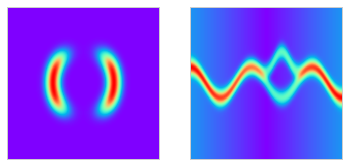

In [9]:
size = 301
_,_,z = make_grids_for_plot(n_grids=size)
z = tf.cast(z, tf.float32)

for i,prob in enumerate([target_prob1, target_prob2]):
  p = prob(z).numpy().reshape(size,size)
  plt.subplot(1,2,i+1)
  plt.imshow(p,cmap='rainbow')
  plt.xticks([])
  plt.yticks([])

# Experiments

## Util

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Optimization

In [0]:
base_dist = tfd.MultivariateNormalDiag(loc=0., scale_diag=[1.,1.])
trainer1 = Trainer(base_dist, PlanarFlow(2,10), target_prob1)
# trainer2 = Trainer(base_dist, PlanarFlow(2,10), target_prob2)

In [22]:
N_EPOCHS = 10000
N_SAMPLES = 500
LR = 1e-3

lst_trainer = [trainer1,]
lst_loss = []

for i,trainer in enumerate(lst_trainer):
  print('\nTarget Prob %i'%(i))
  optimizer = tfk.optimizers.Adam(LR)
  with measure_time(), overwriting_stdout():
    l = trainer.train(N_EPOCHS+1, N_SAMPLES, optimizer)
  lst_loss.append(l)


Target Prob 0
Epoch 10000: Loss = -1.814303
Elapsed Time 116.154781 [sec]


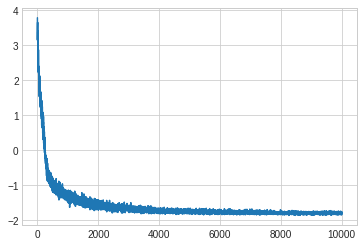

In [23]:
for loss in lst_loss: plt.plot(loss)

# Results

## Transformed Densities

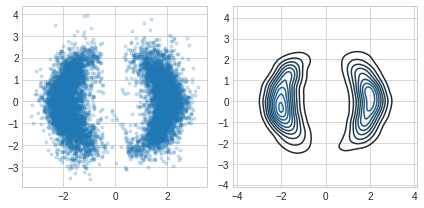

In [24]:
z0 = base_dist.sample(10000)
logq0 = base_dist.log_prob(z0)

n = len(lst_trainer)
fig, axes = plt.subplots(n, 2, figsize=[6,3])
axes = np.ravel(axes)

for i, trainer in enumerate(lst_trainer):
  flow = trainer.flow
  zk, logqk = flow(z0, logq0)
  x, y = zk[:,0].numpy(), zk[:,1].numpy()
  
  ax = axes[2*i]
  ax.scatter(x, y, alpha=0.2, marker='.')
  ax = axes[2*i+1]
  sns.kdeplot(x, y, ax=ax)

plt.tight_layout()

## Transformation Processes

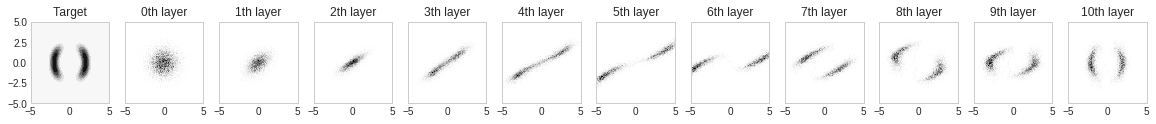

In [25]:
max_figs = 12
size = 101
_min, _max = -5., 5
target_p = target_prob1
flow = trainer1.flow

# For target prob
x, y, z = make_grids_for_plot(min_xy=_min, max_xy=_max, n_grids=size)
target_p = target_p(z).numpy().reshape(size,size)

# For q_k
z0 = tf.cast(base_dist.sample(10000), tf.float32)
logq0 = tf.cast(base_dist.log_prob(z0), tf.float32)

# Plot figs
fig, axes = plt.subplots(1,max_figs,figsize=[20,1.5],sharex=True,sharey=True)
axes[0].contourf(x,y,target_p)
axes[0].set_title('Target')

for i, k in zip(range(1, max_figs), range(0, max_figs)):
  if k == 0:
    zk, logqk = z0, logq0
  else:
    zk, logqk = flow(z0, logq0, k_stop=k)
  axes[i].hist2d(zk[:,0], zk[:,1], range=[[_min,_max],[_min,_max]], bins=size, density=True)
  axes[i].set_title('{}th layer'.format(k))
  axes[i].set_xlim(_min,_max)
  axes[i].set_ylim(_min,_max)

# References

1. https://arxiv.org/abs/1505.05770
1. https://qiita.com/yuto_hito/items/62192b4dd1cd9cbaa170
1. https://blog.evjang.com/2018/01/nf1.html